# Overview 

This project is a submission to [AllenNLP Hackathon](https://allennlp-hackathon.apps.allenai.org/) with following team members - Tahsin Mayeesha, Khalid Saifullah and Atuhurra Jesse. 

# Task 

We picked [Semeval 2022 task 5 : Multimedia Automatic Misogyny Identification (MAMI)](https://competitions.codalab.org/competitions/34175) as our project. Here the task is to identify microaggression against women that is spread online via meme's. 

According to task description : 


***Women have a strong presence online, particularly in image-based social media such as Twitter and Instagram: 78% of women use social media multiple times per day compared to 65% of men...............Although most of them are created with the intent of making funny jokes, in a short time people started to use them as a form of hate against women, landing to sexist and aggressive messages in online environments that subsequently amplify the sexual stereotyping and gender inequality of the offline world.***

The proposed task, i.e. Multimedia Automatic Misogyny Identification (MAMI) consists in the identification of misogynous memes, taking advantage of both text and images available as source of information. The task will be organized around two main sub-tasks:

**Sub-task A:** a basic task about misogynous meme identification, where a meme should be categorized either as misogynous or not misogynous;


# Approach

* We have tried to train two seperate models. First one is the model in this colab that uses [CLIP](https://openai.com/blog/clip/) by openai via huggingface transformers. We extract text and image embeddings from clip and train the multimodal task via a fusion model with pytorch lightning to avoid boilerplate code. Our training loss reduced from 0.69 on the binary classification problem to classify a meme as misogynist vs non-misogynist to 0.483 after 10 epochs. We found multimodal training extremely slow in practice despite increasing learning rate. 

![](https://github.com/Tahsin-Mayeesha/allenlp-hacks/blob/main/new.png?raw=true)

![](https://github.com/Tahsin-Mayeesha/allenlp-hacks/blob/main/HatefulMemeDetector_Pipeline.png?raw=true)


* Our second model was Huggingface's [MMBT](https://github.com/facebookresearch/mmbt). However while we were able to modify the script to acccomodate current dataset from multimodal IMDB, a bug in the model couldn't be worked out.



# Resources 

* https://www.drivendata.co/blog/hateful-memes-benchmark/ for modifying to current model with significant changes.

# Computational Resources

- Google colab general, 1 GPU, 10k image dataset




In [1]:
%%capture
!pip install transformers

# from PIL import Image
# import requests

# import torch
# from torchvision.datasets import CIFAR100

# from transformers import CLIPProcessor, CLIPModel

# # Load the model
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Download the dataset
# cifar100 = CIFAR100(root='./', download=True, train=False)

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# text_inputs = [f"a photo of a {c}" for c in cifar100.classes]

# inputs = processor(text=text_inputs, images=image, return_tensors="pt", padding=True).to(device)

# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# values, indices = probs[0].topk(5)

# # Print the result
# print("\nTop predictions:\n")
# for value, index in zip(values, indices):
#     print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

# HATEFUL MEMES DETECTION WITH CLIP

In [2]:
%%capture
!pip install pandas-path

%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm.auto import tqdm

import torch                    
import torchvision

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
csv_path = '/content/drive/My Drive/Mami Dataset/TRAINING/training.csv'
data_dir = '/content/drive/My Drive/Mami Dataset/TRAINING'

# for binary classification, all fields aren't necessary
fields = ["file_name", "misogynous", "Text Transcription"]
train_samples_frame = pd.read_csv(csv_path, sep='\t', usecols=fields)
train_samples_frame

,file_name,misogynous,Text Transcription
0,1.jpg,0,Milk Milk.zip
1,10.jpg,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...
9995,15002.jpg,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,COOKING FOR MY WIFE imgflip.com


In [ ]:
train_samples_frame['misogynous'].value_counts()

1    5000
0    5000
Name: misogynous, dtype: int64

# EXPLORING THE TEXT DATA

In [5]:
train_samples_frame["Text Transcription"].map(
    lambda text: len(text.split(" "))
).describe()

count    10000.000000
mean        18.058000
std         15.053514
min          1.000000
25%         10.000000
50%         15.000000
75%         21.000000
max        269.000000
Name: Text Transcription, dtype: float64

# EXPLORING THE IMAGE DATA

In [6]:
from PIL import Image


images = [
    Image.open(
        "/".join((data_dir, train_samples_frame.loc[i, "file_name"]))
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(640, 585)
(640, 640)
(526, 640)
(426, 640)
(640, 489)


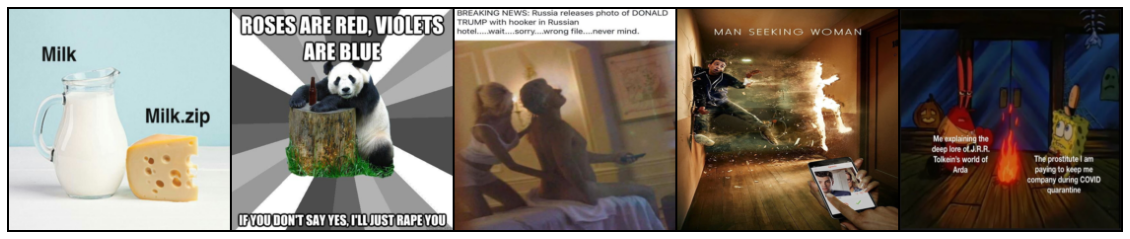

In [7]:
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

# BUILDING A MULTIMODAL MODEL

- ## CREATING A MULTIMODAL DATASET

In [8]:
from sklearn.model_selection import train_test_split

!mkdir /content/data
save_path = "/content/data"

train_df, test_df = train_test_split(train_samples_frame, test_size=0.2, random_state=101, stratify=train_samples_frame["misogynous"])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=101, stratify=train_df["misogynous"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# saving the data as csv, so we don't need to load all audio files into memory
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
val_df.to_csv(f"{save_path}/val.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_df['misogynous'].value_counts())
print(val_df['misogynous'].value_counts())
print(test_df['misogynous'].value_counts())

(7200, 3)
(800, 3)
(2000, 3)
1    3600
0    3600
Name: misogynous, dtype: int64
1    400
0    400
Name: misogynous, dtype: int64
1    1000
0    1000
Name: misogynous, dtype: int64


In [9]:
# !pip install pandas-path
from pandas_path import path
from transformers import CLIPFeatureExtractor, CLIPTokenizerFast, CLIPModel

class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses csv data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, data_path, img_dir, random_state=0,):

        fields = ["file_name", "misogynous", "Text Transcription"]
        self.samples_frame = pd.read_csv(data_path, sep='\t', usecols=fields)
        self.samples_frame = self.samples_frame.reset_index(drop=True)
        self.samples_frame.file_name = self.samples_frame.apply(lambda row: "/".join((img_dir, row.file_name)), axis=1)

        # print(self.samples_frame.file_name.path.exists().where(lambda i: i!=True).dropna())
        # https://github.com/drivendataorg/pandas-path
        if not self.samples_frame.file_name.path.exists().all():
            raise FileNotFoundError
        if not self.samples_frame.file_name.path.is_file().all():
            raise TypeError
            
        self.image_transform = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
        self.text_transform = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenized_texts = self.text_transform(self.samples_frame['Text Transcription'].tolist(), truncation=True)

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = pd.Series(self.samples_frame.loc[idx, "file_name"]).apply(lambda i: int(i.split('/')[-1].split('.')[0])).values

        image = Image.open(
            self.samples_frame.loc[idx, "file_name"]
        ).convert("RGB")
        pixel_values = self.image_transform(image, do_resize=True, size=224)['pixel_values'][0]

        input_ids = torch.tensor(self.tokenized_texts['input_ids'][idx])

        
        if "misogynous" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "misogynous"]]
            ).long().squeeze()
            sample = {
                'input_ids': input_ids,
                'pixel_values': pixel_values,
                "id": img_id,
                "label": label
            }
        else:
            sample = {
                'input_ids': input_ids,
                'pixel_values': pixel_values,
                "id": img_id,
            }

        return sample

- ## CREATING A MULTIMODAL MODEL.

In [11]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(self, num_classes, loss_fn, clip_model, fusion_output_size, dropout_p):
        super(LanguageAndVisionConcat, self).__init__()
        self.clip_model = clip_model
        self.fusion = torch.nn.Linear(
            in_features=(512 + 512), # CLIP's text embedding dim. + image embedding dim. = 512 + 512
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, input_ids, pixel_values, label=None):
        with torch.inference_mode():
          outputs = self.clip_model(input_ids=input_ids, pixel_values=pixel_values)
          # logits_per_image = outputs.logits_per_image # this is the image-text similarity score

        text_features = torch.nn.functional.relu(outputs['text_embeds'])
        image_features = torch.nn.functional.relu(outputs['image_embeds'])

        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

# TRAINING A MULTIMODAL MODEL

In [12]:
%%capture
!pip install pytorch-lightning

In [39]:
import pytorch_lightning as pl
from transformers import DataCollatorWithPadding

# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        self.save_hyperparameters()
        super().__init__()
        self.hparams.update(hparams)
        
        # assign some hparams that get used in multiple places
        # self.embedding_dim = self.hparams.get("embedding_dim", 300)
        # self.language_feature_dim = self.hparams.get(
        #     "language_feature_dim", 300
        # )
        # self.vision_feature_dim = self.hparams.get(
        #     # balance language and vision features by default
        #     "vision_feature_dim", self.language_feature_dim
        # )
        self.output_path = Path(
            self.hparams.get("output_path", "model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        # self.text_transform = self._build_text_transform()
        # self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset(self.hparams["train_path"])
        self.dev_dataset = self._build_dataset(self.hparams["dev_path"])
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, input_ids, pixel_values, label=None):
        return self.model(input_ids, pixel_values, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            input_ids=batch["input_ids"],
            pixel_values=batch["pixel_values"],
            label=batch["labels"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            input_ids=batch["input_ids"],
            pixel_values=batch["pixel_values"],
            label=batch["labels"]
        )
        
        return {"batch_val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters())
        
        # monitor = [self.hparams.get("early_stop_monitor", "avg_val_loss")],
        return {
          "optimizer": optimizer}
          #"lr_scheduler": {
              #"scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer),
              #"monitor": "metric_to_track",
          #},
        #}
    
    def train_dataloader(self):
        data_collator = DataCollatorWithPadding(tokenizer=self.train_dataset.text_transform)

        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16),
            collate_fn=data_collator,
        )

    def val_dataloader(self):
        data_collator = DataCollatorWithPadding(tokenizer=self.dev_dataset.text_transform)
        return torch.utils.data.DataLoader(
            self.dev_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16),
            collate_fn=data_collator,
        )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    
  

    def _build_dataset(self, dataset_key):
        return HatefulMemesDataset(
            data_path=dataset_key,
            img_dir=self.hparams.get("img_dir")
        )
    
    def _build_model(self):
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        #clip_model.eval()

        # vision_module.fc = torch.nn.Linear(
        #         in_features=2048,
        #         out_features=self.vision_feature_dim
        # )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            clip_model=clip_model,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            save_last = True,
            monitor=self.hparams.get(
                "checkpoint_monitor", "avg_val_loss"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "avg_val_loss"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 3
            ),
            verbose=self.hparams.get("verbose", True),
        )

        trainer_params = {
            #"callbacks": [checkpoint_callback, early_stop_callback],
            "callbacks": [checkpoint_callback],
            "default_root_dir": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
            
    @torch.inference_mode()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset["file_name"].apply(lambda img_name: img_name.split('.')[0]),
            columns=["proba", "label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(preprocessed_text_and_image=batch["input"])
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame

In [45]:
train_path = '/content/data/train.csv'
dev_path = '/content/data/val.csv'
data_dir = '/content/drive/My Drive/Mami Dataset/TRAINING'

hparams = {
    
    # Required hparams
    "train_path": train_path,
    "dev_path": dev_path,
    "img_dir": data_dir,
    
    # Optional hparams
    #"embedding_dim": 150,
    #"language_feature_dim": 300,
    #"vision_feature_dim": 300,
    #"fusion_output_size": 256,
    "output_path": "model-outputs",
    "dev_limit": None,
    "lr": 0.00001,
    "max_epochs": 10,
    "n_gpu": 1,
    "batch_size": 4,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
}

hateful_memes_model = HatefulMemesModel(hparams=hparams)


In [46]:
hateful_memes_model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | LanguageAndVisionConcat | 151 M 
--------------------------------------------------
151 M     Trainable params
0         Non-trainable params
151 M     Total params
607.213   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Training: -1it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d7a549e0>
Traceback (most recent call last):
Traceback (most recent call last):
    self._shutdown_workers()
Exception

Validating: 0it [00:00, ?it/s]

Epoch 1, global step 225: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 338: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 451: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 564: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 677: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 790: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 903: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 1016: avg_val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 1129: avg_val_loss was not in top 1
Saving latest checkpoint...


In [43]:
checkpoints = list(Path("model-outputs").glob("*.ckpt"))
assert len(checkpoints) == 1

checkpoints

[PosixPath('model-outputs/last.ckpt')]

In [53]:
!cp /content/model-outputs/last.ckpt /content/drive/MyDrive/

Wandb link : https://wandb.ai/khalidsaifullaah/wandb-lightning/overview?workspace=user-khalidsaifullaah

![](https://github.com/Tahsin-Mayeesha/allenlp-hacks/blob/main/wandb_run.png?raw=true)